In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd

import decay
from prep import GCS_FILE_PATH, CRS

region = "CentralCal"

In [2]:
all_pois = gpd.read_parquet(
    f"{GCS_FILE_PATH}all_pois.parquet",
    filters = [[("region", "==", region)]]
)

/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.


<AxesSubplot:>

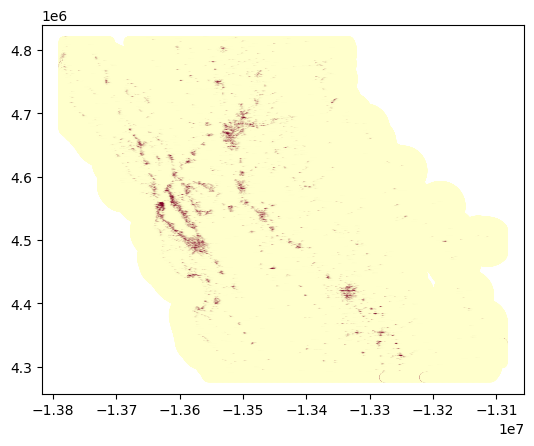

In [3]:
all_pois.plot("grid_code", cmap="YlOrRd", scheme="quantiles")

In [4]:
sjoin = dd.read_parquet(
    f"{GCS_FILE_PATH}sjoin_pairs_{region}/",
)

In [5]:
region_oppor = decay.decay_weighted_opportunities(
    sjoin,
    distance_col = "dist",
    speed_mph = 10,
    time_cutoff_min = 60,
)

In [6]:
access = decay.aggregate_by_origin(region_oppor).compute()

In [7]:
results = pd.merge(
    all_pois,
    access,
    on = "poi_index",
    how = "left",
    validate = "1:1",
)

results = results.assign(
    decay_weighted_opps = results.decay_weighted_opps.fillna(0)
)

<AxesSubplot:>

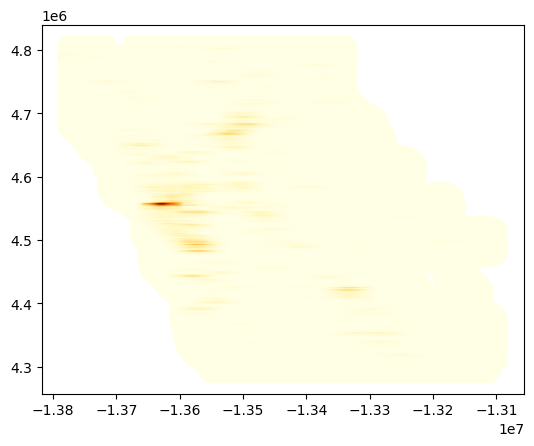

In [8]:
results.plot(
    "decay_weighted_opps", 
    cmap="YlOrBr", 
)

In [9]:
sjoin_agg = (sjoin.groupby("origin_poi_index")
             .agg({"dist": "sum"})
             .reset_index()
            ).compute()

results2 = pd.merge(
    all_pois,
    sjoin_agg,
    left_on = "poi_index",
    right_on = "origin_poi_index",
    how = "left",
    validate = "1:1",
)

<AxesSubplot:>

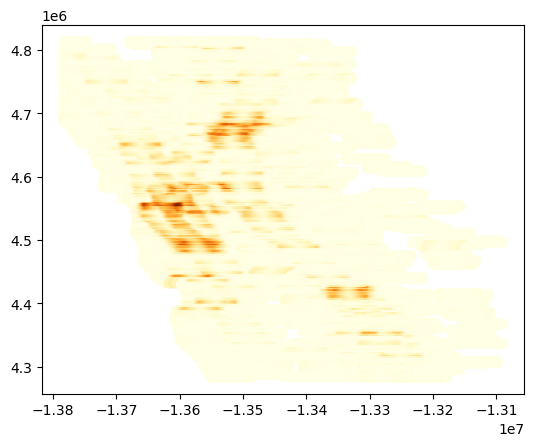

In [10]:
results2.plot("dist", cmap="YlOrBr")

In [11]:
one_poi = all_pois[all_pois.grid_code > 4].poi_index.unique()[0]

In [12]:
all_pois[all_pois.poi_index==one_poi]

,pointid,grid_code,Point_ID,geometry,region,x,y,poi_index
79358,127544,8,id_127544,POINT (-13602580.680 4796729.273),CentralCal,-1.360258e+07,4.796729e+06,79358


In [13]:
results[results.poi_index==one_poi]

,pointid,grid_code,Point_ID,geometry,region,x,y,poi_index,decay_weighted_opps
79358,127544,8,id_127544,POINT (-13602580.680 4796729.273),CentralCal,-1.360258e+07,4.796729e+06,79358,60.477705
